In [1]:
import laspy
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm import tqdm

In [2]:
classes = {
    'terrain': 0,
    'low_vegetation': 1,
    'stem': 2,
    'canopy': 3
}

In [3]:
for_instance_intensities = []
folder = Path('./FORinstance_dataset')
extensions = ('.laz', '.las')
for_instance_files = sorted(
            [f for f in folder.rglob("*") if f.is_file() and f.suffix.lower() in extensions],
            key=lambda f: f.name
        )

for i, path in enumerate(tqdm(for_instance_files)):
    ext = path.suffix.lower()
    file = laspy.read(path)

    min_x = np.min(file.x)
    min_y = np.min(file.y)
    min_z = np.min(file.z)

    max_x = np.max(file.x)
    max_y = np.max(file.y)
    
    # print(f'Tamaño: ({(max_x - min_x):.2f}, {(max_y - min_y):.2f})')

    x = file.x - min_x
    y = file.y - min_y
    z = file.z - min_z
    
    mask = (file.classification != 3) & (file.classification != 0)  # Eliminamos puntos no clasificados o inválidos
    file.points = file.points[mask]

    semantic_labels = np.array(file.classification)
    remap = np.copy(semantic_labels)

    remap = np.where(semantic_labels == 1, classes['low_vegetation'], remap)
    remap = np.where(semantic_labels == 2, classes['terrain'], remap)
    remap = np.where(semantic_labels == 4, classes['stem'], remap)
    remap = np.where(semantic_labels == 5, classes['canopy'], remap)
    remap = np.where(semantic_labels == 6, classes['canopy'], remap)

    for_instance_intensities.append(np.array(file.intensity))

    file.classification = remap
    
    intensity = np.array(file.intensity)
    min_intensity = np.min(intensity)
    max_intensity = np.max(intensity)
    file.add_extra_dims([laspy.ExtraBytesParams(name="I_norm", type=np.float32), laspy.ExtraBytesParams(name="wavelength", type=np.int16)])
    file.I_norm = (intensity - min_intensity) / (max_intensity - min_intensity)
    file.wavelength = np.full(intensity.shape, fill_value=1550, dtype=np.int16) if path.parent.name == 'CULS' else np.full(intensity.shape, fill_value=905, dtype=np.int16)
    file.write(f'./Corrected/FORinstance/plot_{i}{ext}')


100%|██████████| 28/28 [00:50<00:00,  1.81s/it]


In [4]:
nibio_intensities = []
start_idx = 28
folder = Path('./NIBIO_MLS')
extensions = ('.laz', '.las')
for_instance_files = sorted(
            [f for f in folder.rglob("*") if f.is_file() and f.suffix.lower() in extensions],
            key=lambda f: f.name
        )

for i, path in enumerate(tqdm(for_instance_files)):
    ext = path.suffix.lower()
    file = laspy.read(path)

    min_x = np.min(file.x)
    min_y = np.min(file.y)
    min_z = np.min(file.z)

    max_x = np.max(file.x)
    max_y = np.max(file.y)
    
    # print(f'Tamaño: ({(max_x - min_x):.2f}, {(max_y - min_y):.2f})')

    x = file.x - min_x
    y = file.y - min_y
    z = file.z - min_z

    semantic_labels = np.array(file.label)
    ids = np.array(file.treeID)
    remap = np.copy(semantic_labels)

    remap = np.where(semantic_labels == 1, classes['terrain'], remap)
    remap = np.where((semantic_labels == 2) & (ids == 0), classes['low_vegetation'], remap)
    remap = np.where((semantic_labels == 2) & (ids != 0), classes['canopy'], remap)
    remap = np.where(semantic_labels == 3, classes['low_vegetation'], remap)
    remap = np.where(semantic_labels == 4, classes['stem'], remap)

    nibio_intensities.append(np.array(file.intensity))

    file.classification = remap
    intensity = np.array(file.intensity)
    min_intensity = np.min(intensity)
    max_intensity = np.max(intensity)
    file.add_extra_dims([laspy.ExtraBytesParams(name="I_norm", type=np.float32), laspy.ExtraBytesParams(name="wavelength", type=np.int16)])
    file.I_norm = (intensity - min_intensity) / (max_intensity - min_intensity)
    file.wavelength = np.full(intensity.shape, fill_value=905, dtype=np.int16)
    file.write(f'./Corrected/NIBIO_MLS/plot_{i + start_idx}{ext}')


100%|██████████| 64/64 [02:14<00:00,  2.09s/it]


In [5]:
for_instance_intensities = np.concatenate(for_instance_intensities)
nibio_intensities = np.concatenate(nibio_intensities)

with open('for_instance_intensities.npy', 'wb') as f:
    np.save(f, for_instance_intensities)

with open('nibio_intensities.npy', 'wb') as f:
    np.save(f, nibio_intensities)

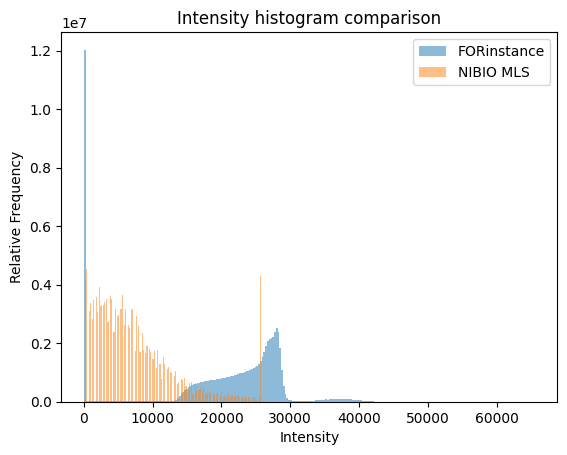

In [6]:
plt.hist(for_instance_intensities, bins=256, alpha=0.5, label='FORinstance')
plt.hist(nibio_intensities, bins=256, alpha=0.5, label='NIBIO MLS')
plt.xlabel('Intensity')
plt.ylabel('Relative Frequency')
plt.title('Intensity histogram comparison')
plt.legend()
plt.show()